In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : True,
    'balance_bins'  : 40,
    'balance_ratio' : 1,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_40_1_1_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 828)
(734160, 1)
validation
(101248, 828)
(101248, 1)
test
(100432, 828)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 1:55 - loss: 0.0591 - STD: 2.1850e-04 - MAE: 0.2334

 4/74 [>.............................] - ETA: 1s - loss: 0.0311 - STD: 3.4780e-04 - MAE: 0.1352  

 5/74 [=>............................] - ETA: 2s - loss: 0.0314 - STD: 3.2729e-04 - MAE: 0.1365

 6/74 [=>............................] - ETA: 2s - loss: 0.0311 - STD: 3.1686e-04 - MAE: 0.1358

 7/74 [=>............................] - ETA: 2s - loss: 0.0302 - STD: 3.1884e-04 - MAE: 0.1328

 8/74 [==>...........................] - ETA: 3s - loss: 0.0287 - STD: 3.3083e-04 - MAE: 0.1270

 9/74 [==>...........................] - ETA: 3s - loss: 0.0271 - STD: 3.5214e-04 - MAE: 0.1200

10/74 [===>..........................] - ETA: 3s - loss: 0.0256 - STD: 3.7920e-04 - MAE: 0.1145

11/74 [===>..........................] - ETA: 3s - loss: 0.0244 - STD: 4.0879e-04 - MAE: 0.1118

12/74 [===>..........................] - ETA: 3s - loss: 0.0237 - STD: 4.3893e-04 - MAE: 0.1114

13/74 [====>.........................] - ETA: 3s - loss: 0.0232 - STD: 4.6791e-04 - MAE: 0.1119

14/74 [====>.........................] - ETA: 3s - loss: 0.0228 - STD: 4.9694e-04 - MAE: 0.1124

15/74 [=====>........................] - ETA: 3s - loss: 0.0223 - STD: 5.2474e-04 - MAE: 0.1123

16/74 [=====>........................] - ETA: 3s - loss: 0.0218 - STD: 5.4918e-04 - MAE: 0.1112

17/74 [=====>........................] - ETA: 3s - loss: 0.0212 - STD: 5.7192e-04 - MAE: 0.1093

18/74 [======>.......................] - ETA: 3s - loss: 0.0207 - STD: 5.9199e-04 - MAE: 0.1070

19/74 [======>.......................] - ETA: 2s - loss: 0.0203 - STD: 6.1024e-04 - MAE: 0.1046

20/74 [=======>......................] - ETA: 2s - loss: 0.0199 - STD: 6.2652e-04 - MAE: 0.1024

21/74 [=======>......................] - ETA: 2s - loss: 0.0196 - STD: 6.4184e-04 - MAE: 0.1004

22/74 [=======>......................] - ETA: 2s - loss: 0.0194 - STD: 6.5697e-04 - MAE: 0.0987

23/74 [========>.....................] - ETA: 2s - loss: 0.0191 - STD: 6.7252e-04 - MAE: 0.0972

24/74 [========>.....................] - ETA: 2s - loss: 0.0189 - STD: 6.9006e-04 - MAE: 0.0956

25/74 [=========>....................] - ETA: 2s - loss: 0.0187 - STD: 7.1004e-04 - MAE: 0.0943

26/74 [=========>....................] - ETA: 2s - loss: 0.0184 - STD: 7.3150e-04 - MAE: 0.0930

27/74 [=========>....................] - ETA: 2s - loss: 0.0182 - STD: 7.5622e-04 - MAE: 0.0920

28/74 [==========>...................] - ETA: 2s - loss: 0.0180 - STD: 7.8246e-04 - MAE: 0.0913

29/74 [==========>...................] - ETA: 2s - loss: 0.0178 - STD: 8.1082e-04 - MAE: 0.0908

30/74 [===========>..................] - ETA: 2s - loss: 0.0176 - STD: 8.4076e-04 - MAE: 0.0905

31/74 [===========>..................] - ETA: 2s - loss: 0.0175 - STD: 8.7167e-04 - MAE: 0.0904

32/74 [===========>..................] - ETA: 2s - loss: 0.0173 - STD: 9.0408e-04 - MAE: 0.0903

33/74 [============>.................] - ETA: 2s - loss: 0.0171 - STD: 9.3665e-04 - MAE: 0.0900

34/74 [============>.................] - ETA: 2s - loss: 0.0170 - STD: 9.6955e-04 - MAE: 0.0897

35/74 [=============>................] - ETA: 2s - loss: 0.0168 - STD: 0.0010 - MAE: 0.0892    

36/74 [=============>................] - ETA: 2s - loss: 0.0168 - STD: 0.0010 - MAE: 0.0886

39/74 [==============>...............] - ETA: 2s - loss: 0.0164 - STD: 0.0011 - MAE: 0.0867

41/74 [===============>..............] - ETA: 2s - loss: 0.0162 - STD: 0.0012 - MAE: 0.0854

42/74 [================>.............] - ETA: 2s - loss: 0.0161 - STD: 0.0013 - MAE: 0.0848

43/74 [================>.............] - ETA: 2s - loss: 0.0160 - STD: 0.0013 - MAE: 0.0843

44/74 [================>.............] - ETA: 2s - loss: 0.0159 - STD: 0.0014 - MAE: 0.0839

45/74 [=================>............] - ETA: 2s - loss: 0.0158 - STD: 0.0014 - MAE: 0.0835

46/74 [=================>............] - ETA: 1s - loss: 0.0157 - STD: 0.0015 - MAE: 0.0832

47/74 [==================>...........] - ETA: 1s - loss: 0.0156 - STD: 0.0015 - MAE: 0.0830

48/74 [==================>...........] - ETA: 1s - loss: 0.0155 - STD: 0.0016 - MAE: 0.0828

49/74 [==================>...........] - ETA: 1s - loss: 0.0154 - STD: 0.0017 - MAE: 0.0826

50/74 [===================>..........] - ETA: 1s - loss: 0.0153 - STD: 0.0018 - MAE: 0.0824

51/74 [===================>..........] - ETA: 1s - loss: 0.0152 - STD: 0.0018 - MAE: 0.0821

52/74 [====================>.........] - ETA: 1s - loss: 0.0151 - STD: 0.0019 - MAE: 0.0819

53/74 [====================>.........] - ETA: 1s - loss: 0.0151 - STD: 0.0020 - MAE: 0.0815

54/74 [====================>.........] - ETA: 1s - loss: 0.0150 - STD: 0.0021 - MAE: 0.0812

55/74 [=====================>........] - ETA: 1s - loss: 0.0149 - STD: 0.0022 - MAE: 0.0809

56/74 [=====================>........] - ETA: 1s - loss: 0.0148 - STD: 0.0023 - MAE: 0.0805

57/74 [======================>.......] - ETA: 1s - loss: 0.0148 - STD: 0.0025 - MAE: 0.0801

58/74 [======================>.......] - ETA: 1s - loss: 0.0147 - STD: 0.0026 - MAE: 0.0798

59/74 [======================>.......] - ETA: 1s - loss: 0.0146 - STD: 0.0027 - MAE: 0.0795

60/74 [=======================>......] - ETA: 0s - loss: 0.0145 - STD: 0.0029 - MAE: 0.0792

61/74 [=======================>......] - ETA: 0s - loss: 0.0144 - STD: 0.0031 - MAE: 0.0789

62/74 [========================>.....] - ETA: 0s - loss: 0.0144 - STD: 0.0033 - MAE: 0.0787

63/74 [========================>.....] - ETA: 0s - loss: 0.0143 - STD: 0.0035 - MAE: 0.0784

64/74 [========================>.....] - ETA: 0s - loss: 0.0142 - STD: 0.0037 - MAE: 0.0782

65/74 [=========================>....] - ETA: 0s - loss: 0.0141 - STD: 0.0039 - MAE: 0.0780

66/74 [=========================>....] - ETA: 0s - loss: 0.0141 - STD: 0.0042 - MAE: 0.0777

67/74 [==========================>...] - ETA: 0s - loss: 0.0140 - STD: 0.0045 - MAE: 0.0774

68/74 [==========================>...] - ETA: 0s - loss: 0.0139 - STD: 0.0048 - MAE: 0.0771

69/74 [==========================>...] - ETA: 0s - loss: 0.0138 - STD: 0.0051 - MAE: 0.0767

70/74 [===========================>..] - ETA: 0s - loss: 0.0137 - STD: 0.0055 - MAE: 0.0764

71/74 [===========================>..] - ETA: 0s - loss: 0.0136 - STD: 0.0059 - MAE: 0.0761

72/74 [============================>.] - ETA: 0s - loss: 0.0136 - STD: 0.0063 - MAE: 0.0757

73/74 [============================>.] - ETA: 0s - loss: 0.0135 - STD: 0.0068 - MAE: 0.0754

74/74 [==============================] - ETA: 0s - loss: 0.0134 - STD: 0.0073 - MAE: 0.0750

74/74 [==============================] - 7s 75ms/step - loss: 0.0134 - STD: 0.0073 - MAE: 0.0750 - val_loss: 0.0073 - val_STD: 0.0333 - val_MAE: 0.0506


Epoch 2/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0064 - STD: 0.0494 - MAE: 0.0501

 2/74 [..............................] - ETA: 4s - loss: 0.0060 - STD: 0.0512 - MAE: 0.0487

 3/74 [>.............................] - ETA: 4s - loss: 0.0059 - STD: 0.0534 - MAE: 0.0481

 4/74 [>.............................] - ETA: 4s - loss: 0.0056 - STD: 0.0553 - MAE: 0.0471

 5/74 [=>............................] - ETA: 4s - loss: 0.0055 - STD: 0.0572 - MAE: 0.0463

 6/74 [=>............................] - ETA: 4s - loss: 0.0053 - STD: 0.0590 - MAE: 0.0456

 7/74 [=>............................] - ETA: 4s - loss: 0.0052 - STD: 0.0607 - MAE: 0.0450

 8/74 [==>...........................] - ETA: 4s - loss: 0.0051 - STD: 0.0624 - MAE: 0.0444

 9/74 [==>...........................] - ETA: 3s - loss: 0.0049 - STD: 0.0642 - MAE: 0.0439

10/74 [===>..........................] - ETA: 3s - loss: 0.0048 - STD: 0.0659 - MAE: 0.0435

11/74 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0675 - MAE: 0.0431

12/74 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0691 - MAE: 0.0427

13/74 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0703 - MAE: 0.0423

14/74 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0712 - MAE: 0.0419

15/74 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0722 - MAE: 0.0416

16/74 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0731 - MAE: 0.0412

17/74 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0409

18/74 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0407

19/74 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0404

20/74 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0402

22/74 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0397

23/74 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0395

24/74 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0393

25/74 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0391

26/74 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0798 - MAE: 0.0389

27/74 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0804 - MAE: 0.0388

28/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0810 - MAE: 0.0386

29/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0815 - MAE: 0.0384

30/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0819 - MAE: 0.0383

31/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0823 - MAE: 0.0381

32/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0826 - MAE: 0.0380

33/74 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0830 - MAE: 0.0379

34/74 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0834 - MAE: 0.0378

35/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0837 - MAE: 0.0377

36/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0840 - MAE: 0.0376

37/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0843 - MAE: 0.0375

38/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0845 - MAE: 0.0374

39/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0847 - MAE: 0.0373

40/74 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0850 - MAE: 0.0372

41/74 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0853 - MAE: 0.0371

42/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0855 - MAE: 0.0370

43/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0857 - MAE: 0.0369

44/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0859 - MAE: 0.0369

45/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0861 - MAE: 0.0368

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0864 - MAE: 0.0367

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0866 - MAE: 0.0367

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0868 - MAE: 0.0366

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0870 - MAE: 0.0366

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0871 - MAE: 0.0365

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0872 - MAE: 0.0365

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0874 - MAE: 0.0364

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0875 - MAE: 0.0364

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0877 - MAE: 0.0363

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0878 - MAE: 0.0363

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0879 - MAE: 0.0362

57/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0881 - MAE: 0.0362

58/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0882 - MAE: 0.0361

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0883 - MAE: 0.0361

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0885 - MAE: 0.0360

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0887 - MAE: 0.0360

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0888 - MAE: 0.0360

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0889 - MAE: 0.0359

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0890 - MAE: 0.0359

65/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0892 - MAE: 0.0358

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0892 - MAE: 0.0358

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0894 - MAE: 0.0358

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0895 - MAE: 0.0357

69/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0896 - MAE: 0.0357

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0897 - MAE: 0.0357

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0898 - MAE: 0.0356

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0900 - MAE: 0.0356

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0900 - MAE: 0.0355

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0901 - MAE: 0.0355

74/74 [==============================] - 5s 63ms/step - loss: 0.0031 - STD: 0.0901 - MAE: 0.0355 - val_loss: 0.0027 - val_STD: 0.0740 - val_MAE: 0.0335


Epoch 3/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0023 - STD: 0.0972 - MAE: 0.0322

 2/74 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.0968 - MAE: 0.0327

 3/74 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0962 - MAE: 0.0328

 4/74 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0970 - MAE: 0.0330

 5/74 [=>............................] - ETA: 4s - loss: 0.0025 - STD: 0.0965 - MAE: 0.0330

 6/74 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0963 - MAE: 0.0331

 7/74 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0963 - MAE: 0.0331

 8/74 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0962 - MAE: 0.0331

 9/74 [==>...........................] - ETA: 3s - loss: 0.0025 - STD: 0.0962 - MAE: 0.0330

10/74 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.0964 - MAE: 0.0331

11/74 [===>..........................] - ETA: 3s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0330

12/74 [===>..........................] - ETA: 3s - loss: 0.0025 - STD: 0.0965 - MAE: 0.0330

13/74 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.0964 - MAE: 0.0330

14/74 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.0961 - MAE: 0.0329

15/74 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0960 - MAE: 0.0329

16/74 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0961 - MAE: 0.0329

17/74 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0962 - MAE: 0.0329

18/74 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0962 - MAE: 0.0329

19/74 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0960 - MAE: 0.0329

20/74 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0960 - MAE: 0.0329

21/74 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0961 - MAE: 0.0329

22/74 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0964 - MAE: 0.0329

23/74 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0964 - MAE: 0.0329

24/74 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.0964 - MAE: 0.0329

25/74 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.0963 - MAE: 0.0329

26/74 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.0963 - MAE: 0.0328

27/74 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.0965 - MAE: 0.0328

28/74 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.0965 - MAE: 0.0328

29/74 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.0965 - MAE: 0.0328

30/74 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0966 - MAE: 0.0328

31/74 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0966 - MAE: 0.0328

32/74 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0965 - MAE: 0.0328

33/74 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0966 - MAE: 0.0327

34/74 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0966 - MAE: 0.0327

35/74 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0966 - MAE: 0.0327

36/74 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0966 - MAE: 0.0327

37/74 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0966 - MAE: 0.0326

38/74 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0326

39/74 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0326

41/74 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.0969 - MAE: 0.0326

42/74 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0969 - MAE: 0.0326

43/74 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0970 - MAE: 0.0326

44/74 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0970 - MAE: 0.0326

45/74 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0971 - MAE: 0.0325

46/74 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0971 - MAE: 0.0325

47/74 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0971 - MAE: 0.0325

48/74 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0971 - MAE: 0.0325

49/74 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0971 - MAE: 0.0325

50/74 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0971 - MAE: 0.0325

51/74 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0971 - MAE: 0.0325

52/74 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0971 - MAE: 0.0324

53/74 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0971 - MAE: 0.0324

54/74 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0972 - MAE: 0.0324

55/74 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0972 - MAE: 0.0324

56/74 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0972 - MAE: 0.0324

57/74 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0972 - MAE: 0.0324

58/74 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0973 - MAE: 0.0324

59/74 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0972 - MAE: 0.0324

60/74 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0972 - MAE: 0.0324

61/74 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0972 - MAE: 0.0324

62/74 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0972 - MAE: 0.0323

63/74 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0972 - MAE: 0.0323

64/74 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0972 - MAE: 0.0323

65/74 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0972 - MAE: 0.0323

66/74 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0972 - MAE: 0.0323

67/74 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0972 - MAE: 0.0323

68/74 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0972 - MAE: 0.0323

69/74 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0972 - MAE: 0.0323

70/74 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0972 - MAE: 0.0322

71/74 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0972 - MAE: 0.0322

72/74 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0972 - MAE: 0.0322

73/74 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0972 - MAE: 0.0322

74/74 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.0972 - MAE: 0.0322

74/74 [==============================] - 5s 63ms/step - loss: 0.0024 - STD: 0.0972 - MAE: 0.0322 - val_loss: 0.0025 - val_STD: 0.0751 - val_MAE: 0.0327


Epoch 4/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0314

 2/74 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.0971 - MAE: 0.0315

 3/74 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0314

 4/74 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0314

 5/74 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0979 - MAE: 0.0313

 6/74 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0313

 7/74 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0313

 8/74 [==>...........................] - ETA: 3s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0313

 9/74 [==>...........................] - ETA: 3s - loss: 0.0023 - STD: 0.0977 - MAE: 0.0313

10/74 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.0977 - MAE: 0.0313

11/74 [===>..........................] - ETA: 3s - loss: 0.0022 - STD: 0.0975 - MAE: 0.0313

12/74 [===>..........................] - ETA: 3s - loss: 0.0022 - STD: 0.0977 - MAE: 0.0313

13/74 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0313

14/74 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.0980 - MAE: 0.0313

15/74 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.0980 - MAE: 0.0313

16/74 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.0980 - MAE: 0.0313

17/74 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.0980 - MAE: 0.0313

18/74 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0980 - MAE: 0.0313

19/74 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0980 - MAE: 0.0313

20/74 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.0980 - MAE: 0.0313

21/74 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.0980 - MAE: 0.0313

22/74 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.0980 - MAE: 0.0313

23/74 [========>.....................] - ETA: 3s - loss: 0.0022 - STD: 0.0982 - MAE: 0.0313

24/74 [========>.....................] - ETA: 3s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0313

25/74 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0313

26/74 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.0980 - MAE: 0.0313

27/74 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.0982 - MAE: 0.0313

28/74 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0313

29/74 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.0980 - MAE: 0.0313

30/74 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0313

31/74 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0982 - MAE: 0.0313

32/74 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0982 - MAE: 0.0313

33/74 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0313

34/74 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0313

35/74 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0982 - MAE: 0.0313

36/74 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0982 - MAE: 0.0313

37/74 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0313

38/74 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0312

39/74 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0982 - MAE: 0.0312

40/74 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0312

41/74 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0312

42/74 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0312

43/74 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0312

45/74 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0312

46/74 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0312

47/74 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0312

48/74 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0312

49/74 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0312

50/74 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0312

51/74 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0311

52/74 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0311

53/74 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0311

54/74 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0311

55/74 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0311

56/74 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0311

57/74 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0311

58/74 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0311

59/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0311

60/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0310

61/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0310

62/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0310

63/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0310

64/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0310

65/74 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0310

66/74 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0310

67/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0310

68/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0310

69/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0310

70/74 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0310

71/74 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0310

72/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0309

73/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0309

74/74 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0309

74/74 [==============================] - 5s 69ms/step - loss: 0.0022 - STD: 0.0985 - MAE: 0.0309 - val_loss: 0.0023 - val_STD: 0.0759 - val_MAE: 0.0310


Epoch 5/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0020 - STD: 0.0973 - MAE: 0.0299

 2/74 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.0974 - MAE: 0.0299

 3/74 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0981 - MAE: 0.0302

 4/74 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.0982 - MAE: 0.0303

 5/74 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0983 - MAE: 0.0303

 6/74 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0304

 7/74 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0304

 8/74 [==>...........................] - ETA: 3s - loss: 0.0021 - STD: 0.0986 - MAE: 0.0303

 9/74 [==>...........................] - ETA: 3s - loss: 0.0021 - STD: 0.0984 - MAE: 0.0303

10/74 [===>..........................] - ETA: 3s - loss: 0.0021 - STD: 0.0984 - MAE: 0.0303

11/74 [===>..........................] - ETA: 3s - loss: 0.0021 - STD: 0.0982 - MAE: 0.0304

12/74 [===>..........................] - ETA: 3s - loss: 0.0021 - STD: 0.0983 - MAE: 0.0303

13/74 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0986 - MAE: 0.0304

14/74 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0984 - MAE: 0.0305

15/74 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0986 - MAE: 0.0305

16/74 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0305

17/74 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0985 - MAE: 0.0306

18/74 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0985 - MAE: 0.0306

19/74 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0306

20/74 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0306

21/74 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0305

22/74 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0305

23/74 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.0985 - MAE: 0.0306

24/74 [========>.....................] - ETA: 2s - loss: 0.0021 - STD: 0.0986 - MAE: 0.0305

25/74 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0306

26/74 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0306

27/74 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.0986 - MAE: 0.0305

28/74 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0305

29/74 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.0986 - MAE: 0.0305

30/74 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0985 - MAE: 0.0305

31/74 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0986 - MAE: 0.0305

32/74 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0985 - MAE: 0.0304

33/74 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0985 - MAE: 0.0304

34/74 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0986 - MAE: 0.0304

35/74 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0986 - MAE: 0.0304

36/74 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0304

37/74 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0304

38/74 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0303

39/74 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0303

40/74 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0303

41/74 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0303

42/74 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0303

43/74 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0303

44/74 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0303

46/74 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0303

47/74 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0304

48/74 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0303

49/74 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0304

50/74 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0304

51/74 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0304

52/74 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0303

53/74 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0303

54/74 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0303

55/74 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0303

56/74 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0303

57/74 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0303

58/74 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0303

59/74 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0303

60/74 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0302

61/74 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0302

62/74 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0302

63/74 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0302

64/74 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0302

65/74 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0302

66/74 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0302

67/74 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0302

68/74 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0302

69/74 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0302

70/74 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0302

71/74 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0301

72/74 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0301

73/74 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0301

74/74 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0301

74/74 [==============================] - 5s 62ms/step - loss: 0.0020 - STD: 0.0993 - MAE: 0.0301 - val_loss: 0.0022 - val_STD: 0.0768 - val_MAE: 0.0302


Epoch 6/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0019 - STD: 0.0978 - MAE: 0.0295

 2/74 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.0992 - MAE: 0.0293

 3/74 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1009 - MAE: 0.0295

 4/74 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0987 - MAE: 0.0304

 5/74 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0991 - MAE: 0.0302

 6/74 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0991 - MAE: 0.0300

 8/74 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.0985 - MAE: 0.0299

 9/74 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.0988 - MAE: 0.0299

10/74 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.0987 - MAE: 0.0302

11/74 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.0991 - MAE: 0.0301

12/74 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0302

13/74 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.0989 - MAE: 0.0303

14/74 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.0989 - MAE: 0.0302

15/74 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0304

16/74 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0988 - MAE: 0.0306

17/74 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0988 - MAE: 0.0306

18/74 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0309

19/74 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0309

20/74 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0310

21/74 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0311

22/74 [=======>......................] - ETA: 2s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0310

23/74 [========>.....................] - ETA: 2s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0311

24/74 [========>.....................] - ETA: 2s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0310

25/74 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0311

26/74 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0310

27/74 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0310

28/74 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0310

29/74 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0310

30/74 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0309

31/74 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0309

32/74 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0309

33/74 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0308

34/74 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0308

35/74 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0308

36/74 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0308

37/74 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0308

38/74 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0308

39/74 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0307

40/74 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0307

41/74 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0307

42/74 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0306

43/74 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0306

44/74 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0306

45/74 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0305

46/74 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0305

47/74 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0305

48/74 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0305

49/74 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0304

50/74 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0304

51/74 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0304

52/74 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0304

53/74 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0304

54/74 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0303

55/74 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0303

56/74 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0303

57/74 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0303

58/74 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0302

59/74 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0302

60/74 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0302

61/74 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0302

62/74 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0302

63/74 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0302

64/74 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0301

65/74 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0301

66/74 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0301

67/74 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0301

68/74 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0301

69/74 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0301

70/74 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0301

71/74 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0301

72/74 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0300

73/74 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0300

74/74 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0300

74/74 [==============================] - 5s 62ms/step - loss: 0.0020 - STD: 0.0996 - MAE: 0.0300 - val_loss: 0.0022 - val_STD: 0.0766 - val_MAE: 0.0302


Epoch 7/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0019 - STD: 0.1017 - MAE: 0.0297

 2/74 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.1014 - MAE: 0.0295

 3/74 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1012 - MAE: 0.0295

 4/74 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1014 - MAE: 0.0296

 5/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0296

 6/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1009 - MAE: 0.0296

 7/74 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1008 - MAE: 0.0295

 8/74 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0295

 9/74 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0295

10/74 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0295

11/74 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0295

12/74 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0294

13/74 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0294

14/74 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0294

15/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0294

16/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0294

17/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0294

18/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0293

19/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0293

20/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0293

21/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0293

22/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0293

23/74 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0293

24/74 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0293

25/74 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0292

27/74 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0292

28/74 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0292

29/74 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0292

30/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0292

31/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0292

32/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0292

33/74 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0291

34/74 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0291

35/74 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0291

36/74 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0291

37/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0291

38/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0291

39/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0291

40/74 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0291

41/74 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0291

42/74 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0291

43/74 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0291

44/74 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0290

45/74 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0290

46/74 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0290

47/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0290

48/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0290

49/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0290

50/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0290

51/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0290

52/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0290

53/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0290

54/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0290

55/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0290

56/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0290

57/74 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0290

58/74 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0290

59/74 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0290

60/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0290

61/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0290

62/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0290

63/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0290

64/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0290

65/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0290

66/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0290

67/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0290

68/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0290

69/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0290

70/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0290

71/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0289

72/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0289

73/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0289

74/74 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0289

74/74 [==============================] - 5s 62ms/step - loss: 0.0019 - STD: 0.1002 - MAE: 0.0289 - val_loss: 0.0021 - val_STD: 0.0773 - val_MAE: 0.0298


Epoch 8/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0018 - STD: 0.0973 - MAE: 0.0290

 2/74 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0292

 3/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0291

 4/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.0999 - MAE: 0.0291

 5/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0290

 6/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.0994 - MAE: 0.0291

 7/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0292

 8/74 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0293

 9/74 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0292

10/74 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0292

11/74 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0292

12/74 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0292

13/74 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0292

14/74 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0291

15/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0291

16/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0291

17/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0291

18/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0291

19/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0291

20/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0291

21/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0291

22/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0291

23/74 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0291

24/74 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0290

25/74 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0290

26/74 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0290

27/74 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0290

28/74 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0290

29/74 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0290

30/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0290

31/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0290

32/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0290

33/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0290

34/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0290

35/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0290

36/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0290

37/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0290

38/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0289

40/74 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0290

41/74 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0290

42/74 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0290

43/74 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0290

44/74 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0290

45/74 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0291

46/74 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0291

47/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0291

48/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0291

49/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0291

50/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0291

51/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0291

52/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0291

53/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0291

54/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0291

55/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0291

56/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0291

57/74 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0291

58/74 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0290

59/74 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0291

60/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0291

61/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0290

62/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0290

63/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0290

64/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0290

65/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0290

66/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0290

67/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0290

68/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0290

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0290

70/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0290

71/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0290

72/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0290

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0290

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0290

74/74 [==============================] - 5s 62ms/step - loss: 0.0018 - STD: 0.1004 - MAE: 0.0290 - val_loss: 0.0021 - val_STD: 0.0799 - val_MAE: 0.0297


Epoch 9/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0293

 2/74 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.1021 - MAE: 0.0291

 3/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1021 - MAE: 0.0288

 4/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0288

 5/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0288

 6/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0288

 7/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0290

 8/74 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0290

 9/74 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0289

10/74 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0289

11/74 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0289

12/74 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0290

13/74 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0289

14/74 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0289

15/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0290

16/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0290

17/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0289

18/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0289

19/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0289

20/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0289

21/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0289

22/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0289

23/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0289

24/74 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0289

25/74 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0289

26/74 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0288

27/74 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0288

28/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0288

30/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0288

31/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0287

32/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0287

33/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0287

34/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0287

35/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0287

36/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0287

37/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0287

38/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0287

39/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0287

40/74 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0287

41/74 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0287

42/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0287

43/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0287

44/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0287

45/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0287

46/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0287

47/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0286

48/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0286

49/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0286

50/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0287

51/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0286

52/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0286

53/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0286

54/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0286

55/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0286

56/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0286

57/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0286

58/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0286

59/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0286

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0286

61/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0286

62/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0286

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0286

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0286

65/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0286

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0286

67/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0286

68/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0286

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0286

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0286

71/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0286

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0286

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0286

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0286

74/74 [==============================] - 5s 62ms/step - loss: 0.0018 - STD: 0.1008 - MAE: 0.0286 - val_loss: 0.0020 - val_STD: 0.0785 - val_MAE: 0.0294


Epoch 10/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0276

 2/74 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0281

 3/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.0992 - MAE: 0.0281

 4/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.0992 - MAE: 0.0279

 5/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.0999 - MAE: 0.0280

 6/74 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1001 - MAE: 0.0279

 7/74 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1003 - MAE: 0.0280

 8/74 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0281

 9/74 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0280

10/74 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1005 - MAE: 0.0280

11/74 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1004 - MAE: 0.0281

12/74 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0282

13/74 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0282

14/74 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0283

15/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0283

16/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0283

17/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0283

18/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0283

19/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0283

20/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0283

21/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0282

22/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0282

23/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0283

25/74 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0283

26/74 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0283

27/74 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0283

28/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0283

29/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0283

30/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0284

31/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0284

32/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0284

33/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0284

34/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0284

35/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0283

36/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0283

37/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0283

38/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0283

39/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0283

40/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0283

41/74 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0283

42/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0283

43/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0284

44/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0286

45/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0287

46/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0287

47/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0287

48/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0287

49/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0287

50/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0287

51/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0287

52/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0287

53/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0287

54/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0287

55/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0287

56/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0287

57/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0287

58/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0287

59/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0287

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0287

61/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0287

62/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0287

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0287

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0287

65/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0287

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0287

67/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0287

68/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0287

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0286

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0286

71/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0286

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0286

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0286

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0286

74/74 [==============================] - 5s 62ms/step - loss: 0.0018 - STD: 0.1008 - MAE: 0.0286 - val_loss: 0.0020 - val_STD: 0.0770 - val_MAE: 0.0290


Epoch 11/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0016 - STD: 0.1004 - MAE: 0.0278

 2/74 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0277

 3/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1004 - MAE: 0.0278

 4/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0278

 5/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0279

 6/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0278

 7/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0278

 8/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0279

 9/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0279

10/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0279

11/74 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0279

12/74 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0279

13/74 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0279

14/74 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0279

15/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0279

16/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0280

17/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0280

18/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0280

19/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0280

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0280

21/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0280

22/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0281

23/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0281

24/74 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0281

25/74 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0280

27/74 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0281

28/74 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0281

29/74 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0281

30/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0281

31/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0281

32/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0281

33/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0281

34/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0281

35/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0281

36/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0281

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0281

38/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0281

40/74 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281

41/74 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0281

42/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281

43/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281

44/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0281

45/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0281

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281

57/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281

58/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0281

59/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0281

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0281

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0281

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0281

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0282

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0281

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0281

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0281

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0281

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0281

74/74 [==============================] - 5s 60ms/step - loss: 0.0017 - STD: 0.1011 - MAE: 0.0281 - val_loss: 0.0020 - val_STD: 0.0788 - val_MAE: 0.0291


Epoch 12/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0017 - STD: 0.1000 - MAE: 0.0282

 2/74 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0285

 3/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0289

 4/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0288

 5/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0287

 6/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0285

 7/74 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0285

 8/74 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0284

 9/74 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0284

10/74 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0283

11/74 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0283

12/74 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0282

13/74 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0282

14/74 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0281

15/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0281

16/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0282

17/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0284

18/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0284

19/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0284

20/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0284

21/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0285

22/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0286

23/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0287

24/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0287

25/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0287

26/74 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0287

27/74 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0287

28/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0286

29/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0286

30/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0286

31/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0286

32/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0285

33/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0285

34/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0285

35/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0285

36/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0285

37/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0285

38/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0284

39/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0284

40/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0284

41/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0284

42/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0284

43/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0283

44/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0283

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0283

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0283

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0283

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0283

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0283

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0283

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0283

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0283

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0282

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0282

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0282

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0282

58/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0282

59/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0282

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0282

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0283

74/74 [==============================] - 5s 68ms/step - loss: 0.0017 - STD: 0.1010 - MAE: 0.0283 - val_loss: 0.0021 - val_STD: 0.0816 - val_MAE: 0.0313


Epoch 13/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0283

 2/74 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1036 - MAE: 0.0283

 3/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1025 - MAE: 0.0291

 4/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1032 - MAE: 0.0292

 5/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1027 - MAE: 0.0290

 6/74 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1026 - MAE: 0.0288

 7/74 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1030 - MAE: 0.0288

 8/74 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1025 - MAE: 0.0289

 9/74 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1026 - MAE: 0.0288

10/74 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1026 - MAE: 0.0288

11/74 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1020 - MAE: 0.0290

12/74 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0290

13/74 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0289

14/74 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0288

15/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0288

16/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0288

17/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0287

18/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0287

19/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0287

20/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0286

21/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0286

22/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0286

23/74 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0286

24/74 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0285

25/74 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0285

26/74 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0285

27/74 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0284

28/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0284

29/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0284

30/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0284

31/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0283

32/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0283

33/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0283

34/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0283

35/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0283

36/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0283

37/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0283

38/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0284

39/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0284

40/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0284

41/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0284

42/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0284

43/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0284

44/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0284

45/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0284

47/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0284

48/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0284

49/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0284

50/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0284

51/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0284

52/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0284

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0284

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0284

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0284

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0283

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0283

58/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0283

59/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0283

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0283

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0283

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0283

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0283

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0283

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0283

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0283

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0282

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0282

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0282

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

74/74 [==============================] - 5s 67ms/step - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282 - val_loss: 0.0020 - val_STD: 0.0816 - val_MAE: 0.0303


Epoch 14/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0275

 2/74 [..............................] - ETA: 5s - loss: 0.0018 - STD: 0.1036 - MAE: 0.0289

 3/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0294

 4/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1028 - MAE: 0.0293

 5/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1033 - MAE: 0.0290

 6/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1034 - MAE: 0.0289

 7/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1026 - MAE: 0.0293

 8/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1032 - MAE: 0.0293

 9/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1031 - MAE: 0.0291

10/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1025 - MAE: 0.0292

11/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1024 - MAE: 0.0293

12/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1022 - MAE: 0.0291

13/74 [====>.........................] - ETA: 4s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0290

14/74 [====>.........................] - ETA: 4s - loss: 0.0018 - STD: 0.1022 - MAE: 0.0291

15/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1021 - MAE: 0.0290

16/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0289

17/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0289

18/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0288

19/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0288

20/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0287

21/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0287

22/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0286

23/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0286

24/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0286

25/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0285

26/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0284

27/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0284

28/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0284

29/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0284

30/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0283

31/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0283

32/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0283

33/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0283

34/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0282

35/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

36/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0282

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

38/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0282

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0282

40/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

41/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0282

42/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

43/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

44/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0282

45/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0282

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0282

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0282

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0282

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0282

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0282

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0282

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0282

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0282

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0282

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0282

58/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0282

59/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0282

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0282

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0282

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0281

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0281

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0281

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0281

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0281

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0281

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

74/74 [==============================] - 5s 69ms/step - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281 - val_loss: 0.0020 - val_STD: 0.0812 - val_MAE: 0.0299


Epoch 15/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0016 - STD: 0.1006 - MAE: 0.0275

 2/74 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.0997 - MAE: 0.0279

 3/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1000 - MAE: 0.0277

 4/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.0999 - MAE: 0.0275

 5/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1000 - MAE: 0.0275

 6/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0278

 7/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0279

 8/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0279

 9/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0279

10/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0279

11/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0279

12/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0279

13/74 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0279

14/74 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0278

15/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0278

16/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0279

17/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0279

18/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0279

19/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0279

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0280

21/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0280

22/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

23/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0281

24/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0281

25/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0281

26/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0281

27/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0281

28/74 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0281

29/74 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0280

30/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0280

31/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0280

32/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0280

33/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0280

34/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0280

35/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0280

36/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0280

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0280

38/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0280

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0280

40/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0280

41/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

42/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

43/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

44/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0279

45/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0279

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0279

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0279

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0279

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0279

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0280

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0279

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0279

58/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0279

59/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0279

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0280

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0279

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0279

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0279

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0279

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0279

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0279

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0279

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0279

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0279

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0279

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0280

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0280

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0280

74/74 [==============================] - 5s 70ms/step - loss: 0.0017 - STD: 0.1014 - MAE: 0.0280 - val_loss: 0.0021 - val_STD: 0.0827 - val_MAE: 0.0317


Epoch 16/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0018 - STD: 0.1064 - MAE: 0.0290

 2/74 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.1010 - MAE: 0.0301

 3/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1027 - MAE: 0.0296

 4/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1022 - MAE: 0.0289

 5/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0288

 6/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0287

 7/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0286

 8/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0284

 9/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0284

10/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0284

11/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0283

12/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0282

13/74 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0282

14/74 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0282

15/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0281

16/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0280

17/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0280

18/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0280

19/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0280

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0280

21/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0280

22/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0279

23/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0279

24/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0279

25/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0279

26/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0278

27/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0278

28/74 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0278

29/74 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0278

30/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0278

31/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0278

32/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0279

33/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0279

34/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0279

35/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0279

36/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0279

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0279

38/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0279

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0279

40/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0279

41/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0279

42/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0279

43/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0279

44/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0279

45/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0279

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0279

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0279

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0279

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0278

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0278

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0278

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0278

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0278

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0278

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0278

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

58/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

59/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0278

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0278

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0278

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0278

74/74 [==============================] - 5s 69ms/step - loss: 0.0017 - STD: 0.1015 - MAE: 0.0278 - val_loss: 0.0020 - val_STD: 0.0811 - val_MAE: 0.0310


Epoch 17/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0017 - STD: 0.1035 - MAE: 0.0284

 2/74 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1005 - MAE: 0.0279

 3/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1001 - MAE: 0.0278

 4/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1000 - MAE: 0.0277

 5/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.0997 - MAE: 0.0278

 6/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0279

 7/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0278

 8/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0278

 9/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0277

10/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0276

11/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0276

12/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0275

13/74 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0275

14/74 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0275

15/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0275

16/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

18/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0275

19/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0275

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0275

21/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0275

22/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0275

23/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0275

24/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0275

25/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0275

26/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0275

27/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0276

28/74 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0276

29/74 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

30/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

31/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

32/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

33/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0277

34/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0276

35/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0276

36/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0276

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0276

38/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0276

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0276

40/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0276

41/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0276

42/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0276

43/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0276

44/74 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

45/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

46/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0275

47/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0275

48/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0275

49/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0276

50/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0276

51/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0276

52/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0276

53/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0276

54/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0276

55/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0276

56/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0276

57/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0276

58/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0276

59/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0276

60/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0276

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0275

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0275

63/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0275

65/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0275

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0275

67/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0276

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0276

69/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0276

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0276

71/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0276

73/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0276

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0276

74/74 [==============================] - 5s 70ms/step - loss: 0.0017 - STD: 0.1015 - MAE: 0.0276 - val_loss: 0.0021 - val_STD: 0.0765 - val_MAE: 0.0299


Epoch 18/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0018 - STD: 0.0968 - MAE: 0.0295

 2/74 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0288

 3/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1027 - MAE: 0.0282

 4/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0282

 6/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1028 - MAE: 0.0289

 7/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1026 - MAE: 0.0288

 8/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0286

 9/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0285

10/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0284

11/74 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0283

12/74 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0283

13/74 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0282

14/74 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0282

15/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0282

16/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0281

17/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0280

18/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0280

19/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0280

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0280

21/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0279

22/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0279

23/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0278

24/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0278

25/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0278

26/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0278

27/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

28/74 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

29/74 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

30/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

31/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

32/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

33/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

34/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0277

35/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

36/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

38/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0277

40/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

41/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0277

42/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0278

43/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0278

44/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0278

45/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0278

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0278

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0278

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0278

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

58/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

59/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0276

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0276

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0276

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0276

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0276

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

74/74 [==============================] - 5s 71ms/step - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277 - val_loss: 0.0019 - val_STD: 0.0804 - val_MAE: 0.0293


Epoch 19/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0270

 2/74 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0271

 3/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0272

 4/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0273

 5/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

 6/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0273

 7/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0274

 8/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0274

 9/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0273

10/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0273

11/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0273

12/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0273

13/74 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

14/74 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

15/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

16/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0273

17/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

18/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

19/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

20/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

21/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

22/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

23/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

24/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0273

25/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

26/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0274

27/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0273

28/74 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0274

29/74 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0274

30/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0275

31/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0275

32/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0275

33/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0275

34/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0275

35/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

36/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0276

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0276

38/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0276

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0276

40/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0277

41/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0277

42/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0277

43/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0277

44/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0277

45/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0278

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0277

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0278

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

58/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0278

59/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0278

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0278

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0278

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0278

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0278

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0278

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0278

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0278

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0278

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0278

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0278

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0278

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

74/74 [==============================] - 5s 69ms/step - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277 - val_loss: 0.0019 - val_STD: 0.0789 - val_MAE: 0.0284


Epoch 20/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0279

 2/74 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

 3/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1031 - MAE: 0.0274

 4/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1035 - MAE: 0.0276

 5/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1038 - MAE: 0.0277

 6/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1031 - MAE: 0.0275

 7/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0275

 8/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0275

 9/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0275

10/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0275

11/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0275

12/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0275

13/74 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0275

14/74 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0274

15/74 [=====>........................] - ETA: 4s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0275

16/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0276

17/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0276

18/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0275

19/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0275

20/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0276

21/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0276

22/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0276

23/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0276

24/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0276

25/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0277

26/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0276

27/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0276

28/74 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0277

29/74 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0277

30/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0277

31/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0276

32/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0276

33/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0276

34/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0276

35/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0276

36/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0276

37/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0276

38/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0276

39/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0276

40/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0276

41/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0276

42/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0275

43/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0275

44/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0275

45/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0275

46/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0276

47/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0275

48/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0275

49/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

50/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

51/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

52/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

53/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

54/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0275

55/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0275

56/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

57/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

58/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

59/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

60/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0275

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

63/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

67/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

69/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0275

71/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0276

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0276

73/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0276

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0276

74/74 [==============================] - 5s 70ms/step - loss: 0.0016 - STD: 0.1016 - MAE: 0.0276 - val_loss: 0.0021 - val_STD: 0.0821 - val_MAE: 0.0320


Epoch 21/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0295

 2/74 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.0996 - MAE: 0.0293

 3/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.0998 - MAE: 0.0283

 4/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0282

 5/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0281

 6/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0281

 7/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0279

 8/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0279

 9/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0278

10/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0277

11/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0276

12/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0276

13/74 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0276

14/74 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0275

15/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0276

16/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0277

17/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

18/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0277

19/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0277

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0277

21/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0277

22/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0277

23/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0276

24/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0276

25/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0276

26/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0276

27/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0276

28/74 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0276

29/74 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0276

30/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0276

31/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0276

32/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

33/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0275

34/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0276

35/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0276

36/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0276

37/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0275

38/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0276

39/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0276

40/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0276

41/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0275

42/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0276

43/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0276

44/74 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0276

45/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0276

46/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0276

47/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0276

48/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0276

49/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0276

50/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0276

51/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0276

52/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0275

53/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

54/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

55/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

56/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

57/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

58/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0275

59/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0275

60/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0275

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0275

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

63/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

65/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

67/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

69/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

71/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

73/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

74/74 [==============================] - 5s 68ms/step - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275 - val_loss: 0.0019 - val_STD: 0.0772 - val_MAE: 0.0282


Epoch 22/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0016 - STD: 0.0994 - MAE: 0.0267

 2/74 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0271

 3/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1004 - MAE: 0.0271

 4/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0270

 5/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0271

 6/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0273

 7/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0274

 8/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1031 - MAE: 0.0274

 9/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0273

10/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0273

11/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

12/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0273

13/74 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

15/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0273

16/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0274

17/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0274

18/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0274

19/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

20/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0275

21/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0275

22/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0275

23/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0275

24/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0275

25/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0276

26/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0276

27/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0275

28/74 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0275

29/74 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0275

30/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

31/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0274

32/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0274

33/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0274

34/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0274

35/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0274

36/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0274

37/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0274

38/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0274

39/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0274

40/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0274

41/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0274

42/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0273

43/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0273

44/74 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0273

45/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0273

46/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0273

47/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0273

48/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0273

49/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0273

50/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0273

51/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0273

52/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

53/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

54/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

55/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

56/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

57/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

58/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

59/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

60/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

63/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

65/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

67/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

69/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

71/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

73/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

74/74 [==============================] - 5s 69ms/step - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273 - val_loss: 0.0023 - val_STD: 0.0744 - val_MAE: 0.0315


Epoch 23/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0021 - STD: 0.0943 - MAE: 0.0324

 2/74 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0302

 3/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0291

 4/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0289

 5/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0287

 6/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0285

 7/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

 8/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0282

 9/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0284

10/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0282

11/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0281

12/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0281

13/74 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0281

14/74 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0280

15/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0279

16/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0278

17/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0278

18/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0278

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0277

21/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0277

22/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0277

23/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0277

24/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0276

25/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0276

26/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0276

27/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0276

28/74 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0275

29/74 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0275

30/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0275

31/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0275

32/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0275

33/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0275

34/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0274

35/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0274

36/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

37/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

38/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

39/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0274

40/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

41/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

42/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

43/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

44/74 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

45/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

46/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

47/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

48/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

49/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

50/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

51/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

52/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

53/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

54/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

55/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

56/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

57/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

58/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

59/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

60/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

63/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

65/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

67/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

69/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

71/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

73/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

74/74 [==============================] - 5s 70ms/step - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274 - val_loss: 0.0018 - val_STD: 0.0792 - val_MAE: 0.0280


Epoch 24/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1006 - MAE: 0.0262

 2/74 [..............................] - ETA: 6s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0271

 3/74 [>.............................] - ETA: 5s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0277

 4/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0275

 5/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0275

 6/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0279

 7/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0282

 8/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0281

 9/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0279

10/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0280

11/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0282

12/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0282

13/74 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0281

14/74 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0280

15/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0279

16/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0279

17/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0278

18/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0278

19/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0278

20/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0277

21/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0277

22/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0277

23/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0277

24/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0277

25/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0277

26/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0277

27/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0277

28/74 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0277

29/74 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0276

30/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0276

31/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0276

32/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0276

33/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0276

34/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0276

35/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

36/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

37/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

38/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

39/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0275

40/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

41/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

42/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

43/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

44/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0274

45/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0274

46/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0274

47/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0274

48/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0274

49/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

50/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

51/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

52/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

53/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0274

54/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

55/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

56/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

57/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

58/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0275

59/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

60/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0274

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0274

63/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0274

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0274

65/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

67/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

69/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

71/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

73/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

74/74 [==============================] - 5s 70ms/step - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274 - val_loss: 0.0020 - val_STD: 0.0829 - val_MAE: 0.0301


Epoch 25/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0016 - STD: 0.1037 - MAE: 0.0278

 2/74 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

 3/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0271

 4/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0272

 5/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0274

 6/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0272

 7/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0271

 8/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0271

 9/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0272

10/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

11/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0273

12/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0273

13/74 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0273

14/74 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

15/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0273

16/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

17/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

18/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0273

19/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0273

20/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0273

21/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0273

22/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

23/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

24/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

25/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

26/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

27/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0273

28/74 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0273

29/74 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0273

30/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

31/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0272

32/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0272

33/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0272

34/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0272

35/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0272

36/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0272

37/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0272

38/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0272

39/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0272

40/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0272

41/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0272

42/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0273

43/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0273

44/74 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0273

45/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0273

46/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0274

47/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0274

48/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0274

49/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0274

50/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0274

51/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0274

52/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0274

53/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

54/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0275

55/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0275

56/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0275

57/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0275

58/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

59/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

60/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

63/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

65/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

67/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

69/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

71/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

73/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

74/74 [==============================] - 5s 69ms/step - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272 - val_loss: 0.0019 - val_STD: 0.0788 - val_MAE: 0.0282


Epoch 26/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0015 - STD: 0.0976 - MAE: 0.0270

 2/74 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1004 - MAE: 0.0272

 3/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0271

 4/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1007 - MAE: 0.0268

 5/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1008 - MAE: 0.0269

 6/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1005 - MAE: 0.0269

 7/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1008 - MAE: 0.0269

 8/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0269

 9/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0269

10/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0269

11/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0269

12/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0269

13/74 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0268

14/74 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0268

15/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0268

16/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0268

17/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0268

18/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0268

19/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

20/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0268

21/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0268

23/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0268

24/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0268

25/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1015 - MAE: 0.0269

26/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0269

27/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0269

28/74 [==========>...................] - ETA: 3s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0269

29/74 [==========>...................] - ETA: 3s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0269

30/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0269

31/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0269

32/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

33/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

34/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

35/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

36/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0271

37/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

38/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0272

39/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0272

40/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0273

41/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0273

42/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0273

43/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0273

44/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0273

45/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0273

46/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0273

47/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0273

48/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0273

49/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0273

50/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0273

51/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0273

52/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0273

53/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0273

54/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0273

55/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0273

56/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

57/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

58/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

59/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

60/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

63/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

65/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

67/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

69/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

71/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

73/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

74/74 [==============================] - 5s 71ms/step - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271 - val_loss: 0.0018 - val_STD: 0.0801 - val_MAE: 0.0284


Epoch 27/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0263

 2/74 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0263

 3/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1032 - MAE: 0.0264

 5/74 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1033 - MAE: 0.0267

 6/74 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1036 - MAE: 0.0269

 7/74 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0273

 8/74 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1033 - MAE: 0.0273

 9/74 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1032 - MAE: 0.0272

10/74 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0271

11/74 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1032 - MAE: 0.0271

12/74 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0271

13/74 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0271

14/74 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0271

15/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0270

16/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1031 - MAE: 0.0270

17/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0270

18/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0270

19/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0270

20/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0270

21/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0270

22/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0270

23/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0269

24/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0269

25/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0270

26/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0270

27/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0270

28/74 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0270

29/74 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0270

30/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0270

31/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0269

32/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0269

33/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0269

34/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0269

35/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0269

36/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0269

37/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0269

38/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0269

39/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0269

40/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0269

41/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0269

42/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0269

43/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0269

44/74 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0269

45/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0269

46/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0269

47/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0269

48/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0269

49/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0269

50/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0269

51/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0269

52/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0269

53/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0269

54/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

55/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

56/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

57/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

58/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

59/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

60/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0269

63/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

69/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

72/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

74/74 [==============================] - 5s 69ms/step - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268 - val_loss: 0.0018 - val_STD: 0.0795 - val_MAE: 0.0281


Epoch 28/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0263

 2/74 [..............................] - ETA: 5s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0263

 3/74 [>.............................] - ETA: 5s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0261

 4/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0263

 5/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0263

 6/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0263

 7/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0264

 8/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0265

 9/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0266

10/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0268

11/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0269

12/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0269

13/74 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0270

14/74 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0272

15/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0274

16/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0275

17/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0274

18/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0274

19/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0273

20/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0274

21/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0274

22/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0273

23/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0273

24/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0272

25/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0272

26/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0272

27/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0271

28/74 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0271

29/74 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0271

30/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0271

31/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

32/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

33/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

34/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

35/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

36/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

37/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0270

38/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

39/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0270

40/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0270

41/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

42/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0271

43/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

44/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0272

45/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

46/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

47/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0272

48/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0273

49/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0273

50/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0273

51/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0273

53/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0273

54/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0273

55/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0272

56/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0272

57/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0272

58/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0272

59/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

60/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

63/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

65/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

67/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0272

69/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0273

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0273

71/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

73/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

74/74 [==============================] - 5s 70ms/step - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272 - val_loss: 0.0018 - val_STD: 0.0791 - val_MAE: 0.0280


Epoch 29/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0263

 2/74 [..............................] - ETA: 5s - loss: 0.0015 - STD: 0.1040 - MAE: 0.0266

 3/74 [>.............................] - ETA: 5s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0269

 4/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1033 - MAE: 0.0269

 5/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0268

 6/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0267

 7/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

 8/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0267

 9/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0267

10/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

11/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0269

12/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0270

13/74 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0270

14/74 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0270

15/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0269

16/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0270

17/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0269

18/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0269

19/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0269

20/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0270

21/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

22/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

24/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

25/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0270

26/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0270

27/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

28/74 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0270

29/74 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

30/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0271

31/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0270

32/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0270

33/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0271

34/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0270

35/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0270

36/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0270

37/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0270

38/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0270

39/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0270

40/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0270

41/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0270

42/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0269

43/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0269

44/74 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

45/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

46/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

47/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

48/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0269

49/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

50/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

51/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

52/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

53/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

54/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

55/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

56/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

57/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

58/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

59/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

60/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0269

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

63/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

69/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

72/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

74/74 [==============================] - 5s 70ms/step - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268 - val_loss: 0.0019 - val_STD: 0.0774 - val_MAE: 0.0282


Epoch 30/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0016 - STD: 0.0986 - MAE: 0.0273

 2/74 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0275

 3/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1007 - MAE: 0.0274

 4/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1012 - MAE: 0.0269

 5/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0269

 6/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

 7/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0271

 8/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0271

 9/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0270

10/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0270

11/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0269

12/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0269

13/74 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0269

14/74 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0268

15/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

16/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

18/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

19/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

20/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

21/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0268

22/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

23/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

24/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

25/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

26/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

27/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

28/74 [==========>...................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

29/74 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0267

30/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0267

31/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0267

32/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0267

33/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0267

34/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0267

35/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

36/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0267

37/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0268

38/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0268

39/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0268

40/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0269

41/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0270

42/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0269

43/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0270

44/74 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0270

45/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0271

46/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0270

47/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0270

48/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0270

49/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0270

50/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0270

51/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0270

52/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0270

53/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0270

54/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0270

55/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0270

56/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0270

57/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0270

58/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0270

59/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

60/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

63/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

69/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

72/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

74/74 [==============================] - 5s 70ms/step - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268 - val_loss: 0.0018 - val_STD: 0.0807 - val_MAE: 0.0290


Epoch 31/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0015 - STD: 0.1006 - MAE: 0.0264

 2/74 [..............................] - ETA: 5s - loss: 0.0015 - STD: 0.0992 - MAE: 0.0266

 3/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1003 - MAE: 0.0267

 4/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1003 - MAE: 0.0267

 5/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1011 - MAE: 0.0267

 6/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

 7/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

 8/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0268

 9/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

10/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0269

11/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0269

12/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0269

13/74 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0269

14/74 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0269

15/74 [=====>........................] - ETA: 4s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0269

16/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0268

17/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0268

18/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0268

19/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

20/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

21/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0268

22/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

23/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0268

24/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

25/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0268

26/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

27/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

28/74 [==========>...................] - ETA: 3s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0268

29/74 [==========>...................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

30/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0268

31/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0268

32/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0268

33/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0268

34/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0268

35/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0268

36/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0268

37/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0268

38/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0268

39/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

40/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0268

41/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

42/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

43/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

44/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

45/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

46/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

47/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

48/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

49/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

50/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

51/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

52/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

53/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

55/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0268

56/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0268

57/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

58/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

59/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

60/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

63/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0268

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

69/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0268

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0268

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

72/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

74/74 [==============================] - 5s 70ms/step - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267 - val_loss: 0.0018 - val_STD: 0.0804 - val_MAE: 0.0281


Epoch 32/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

 2/74 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0265

 3/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1036 - MAE: 0.0264

 4/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0265

 5/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0265

 6/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1015 - MAE: 0.0264

 7/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0265

 8/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0265

 9/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0264

10/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0264

11/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0264

12/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0264

13/74 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0264

14/74 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0264

15/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0264

16/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0264

17/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0264

19/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0264

20/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

21/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0265

22/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

23/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0265

24/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0265

25/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0266

26/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0267

27/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0268

28/74 [==========>...................] - ETA: 3s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0268

29/74 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0268

30/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0268

31/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0270

32/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0271

33/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0271

34/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0271

35/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0271

36/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0271

37/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0271

38/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0271

39/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0271

40/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0270

41/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0270

42/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0270

43/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0270

44/74 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0269

45/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0269

46/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0269

47/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0269

48/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

49/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0268

50/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

51/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

52/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

53/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

54/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

55/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

56/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

57/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0268

58/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0268

59/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0268

60/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0268

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0268

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0268

63/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0268

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0268

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0268

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0268

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0268

69/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0268

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0268

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

72/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

74/74 [==============================] - 5s 69ms/step - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267 - val_loss: 0.0019 - val_STD: 0.0817 - val_MAE: 0.0299


Epoch 33/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0016 - STD: 0.1102 - MAE: 0.0274

 2/74 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1040 - MAE: 0.0272

 3/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1040 - MAE: 0.0269

 4/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1032 - MAE: 0.0267

 5/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

 6/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0266

 7/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0266

 8/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0264

 9/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0264

10/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0264

11/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0265

12/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0266

13/74 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0265

14/74 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0265

15/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0264

16/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0265

17/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0265

18/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0265

19/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

20/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0265

21/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

22/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

23/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0266

24/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

25/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0266

26/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

27/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0267

28/74 [==========>...................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

29/74 [==========>...................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

30/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

31/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

32/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

33/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

34/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

35/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

36/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

37/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

38/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

39/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0267

40/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

41/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0267

42/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0267

43/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

44/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

45/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

46/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

47/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

48/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

49/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

50/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

51/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

52/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

53/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

54/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

55/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

56/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

57/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0267

58/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0267

60/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0266

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0266

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0266

63/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0266

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

69/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

72/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

74/74 [==============================] - 5s 70ms/step - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266 - val_loss: 0.0018 - val_STD: 0.0800 - val_MAE: 0.0281


Epoch 34/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0261

 2/74 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1013 - MAE: 0.0261

 3/74 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1012 - MAE: 0.0261

 4/74 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0261

 5/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1015 - MAE: 0.0262

 6/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0263

 7/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1015 - MAE: 0.0263

 8/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1015 - MAE: 0.0263

 9/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1013 - MAE: 0.0263

10/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1015 - MAE: 0.0263

11/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0263

12/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1014 - MAE: 0.0264

13/74 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0264

14/74 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0263

15/74 [=====>........................] - ETA: 4s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0263

16/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0263

17/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0263

18/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0263

19/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0262

20/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0262

21/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0262

22/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0263

23/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0263

24/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0263

25/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0263

26/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0263

27/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0264

28/74 [==========>...................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0264

29/74 [==========>...................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0265

30/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0264

31/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0264

32/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0265

33/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0265

34/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0265

35/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

36/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0265

37/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0265

38/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0265

39/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0265

41/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0265

42/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0266

43/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

44/74 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0267

45/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0266

46/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

47/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0267

48/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

49/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

50/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

51/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

52/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

53/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

54/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

55/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

56/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

57/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

58/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

59/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

60/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

63/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

69/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

72/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

74/74 [==============================] - 5s 70ms/step - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267 - val_loss: 0.0018 - val_STD: 0.0805 - val_MAE: 0.0286


Epoch 35/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0259

 2/74 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1039 - MAE: 0.0259

 3/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1035 - MAE: 0.0259

 4/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0259

 5/74 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0259

 6/74 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1022 - MAE: 0.0259

 7/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1013 - MAE: 0.0261

 8/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0262

 9/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0262

10/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0262

11/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0262

12/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0263

13/74 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0265

14/74 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0265

15/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0264

16/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0264

17/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0264

18/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0265

19/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0264

20/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0264

21/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0264

22/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0264

23/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0263

24/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0263

25/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0263

26/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0264

27/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0263

28/74 [==========>...................] - ETA: 3s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0263

29/74 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0263

31/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0263

32/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0263

33/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0263

34/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0263

35/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0263

36/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0263

37/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0263

38/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0263

39/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0262

40/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0262

41/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0262

42/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0262

43/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0262

44/74 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0262

45/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0262

46/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0262

47/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0262

48/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0262

49/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0262

50/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0262

51/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0262

52/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0262

53/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0263

54/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0263

55/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0263

56/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0263

57/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

58/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0264

59/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

60/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0264

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0264

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

63/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0265

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0265

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0265

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0265

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0265

69/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0265

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0265

72/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0265

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0265

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0265

74/74 [==============================] - 5s 69ms/step - loss: 0.0015 - STD: 0.1025 - MAE: 0.0265 - val_loss: 0.0019 - val_STD: 0.0756 - val_MAE: 0.0279


Epoch 36/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0015 - STD: 0.0954 - MAE: 0.0265

 2/74 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.0991 - MAE: 0.0260

 3/74 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1004 - MAE: 0.0261

 4/74 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0262

 5/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1003 - MAE: 0.0262

 7/74 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1010 - MAE: 0.0263

 8/74 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0264

 9/74 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0263

10/74 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1012 - MAE: 0.0263

11/74 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0265

12/74 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1013 - MAE: 0.0265

13/74 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0265

14/74 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0265

15/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0265

16/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0265

17/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0264

18/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0264

19/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0263

20/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0263

21/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0263

22/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0264

23/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0265

24/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0264

25/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0264

26/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0265

27/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0265

28/74 [==========>...................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0265

29/74 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0265

30/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0265

31/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0265

32/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0265

33/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0265

34/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0265

35/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0265

36/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0265

37/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0265

38/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0265

39/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0264

40/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0264

41/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0264

42/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0264

43/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0264

44/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0264

45/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0264

46/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0264

47/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0264

48/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0264

49/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0264

50/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0264

51/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0264

52/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0264

53/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0264

54/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0264

55/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0264

56/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0264

57/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0264

58/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

59/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

60/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

63/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0264

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0264

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

69/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

72/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

74/74 [==============================] - 5s 70ms/step - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263 - val_loss: 0.0018 - val_STD: 0.0807 - val_MAE: 0.0290


Epoch 37/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0015 - STD: 0.1037 - MAE: 0.0260

 2/74 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0261

 3/74 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1016 - MAE: 0.0260

 4/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0264

 5/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1013 - MAE: 0.0269

 6/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0271

 7/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0270

 8/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0268

 9/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0267

10/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0266

11/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0265

12/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0264

13/74 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0264

14/74 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0263

16/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0263

17/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0263

18/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0262

19/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0262

20/74 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0262

21/74 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0261

22/74 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0262

23/74 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0261

24/74 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0261

25/74 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0261

26/74 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1022 - MAE: 0.0261

27/74 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1022 - MAE: 0.0261

28/74 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0261

29/74 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1022 - MAE: 0.0260

30/74 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0260

31/74 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0260

32/74 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0261

33/74 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0261

34/74 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0261

35/74 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0261

36/74 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0261

37/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0261

38/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

39/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0261

40/74 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0261

41/74 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0261

42/74 [================>.............] - ETA: 2s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0261

43/74 [================>.............] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

44/74 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0262

45/74 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0262

46/74 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0262

47/74 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0262

48/74 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0262

49/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0262

50/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0262

51/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0263

52/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0263

53/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0263

54/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0263

55/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0263

56/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0263

57/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0263

58/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0263

59/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0263

60/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0263

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0263

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0263

63/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0263

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0263

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0263

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0263

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0263

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0263

69/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0262

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0262

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0262

72/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0262

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0262

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0263

74/74 [==============================] - 5s 70ms/step - loss: 0.0015 - STD: 0.1025 - MAE: 0.0263 - val_loss: 0.0019 - val_STD: 0.0774 - val_MAE: 0.0283


Epoch 38/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0015 - STD: 0.0999 - MAE: 0.0269

 2/74 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1037 - MAE: 0.0264

 3/74 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1048 - MAE: 0.0263

 4/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

 5/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0266

 6/74 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1020 - MAE: 0.0264

 7/74 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1019 - MAE: 0.0263

 8/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0263

 9/74 [==>...........................] - ETA: 4s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0263

10/74 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0262

11/74 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

12/74 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0261

13/74 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0261

14/74 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0261

15/74 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0261

16/74 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0260

17/74 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0260

18/74 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0260

19/74 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0260

20/74 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0260

21/74 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

22/74 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

23/74 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

24/74 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

25/74 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

26/74 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

27/74 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

28/74 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

29/74 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

30/74 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

31/74 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

32/74 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

33/74 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0258

34/74 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0258

35/74 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

36/74 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

37/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

38/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

39/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0259

40/74 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0259

41/74 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

42/74 [================>.............] - ETA: 2s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0260

43/74 [================>.............] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0260

45/74 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0260

46/74 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0260

47/74 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0260

48/74 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0260

49/74 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0260

50/74 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0260

51/74 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0260

52/74 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0260

53/74 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0260

54/74 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0261

55/74 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0261

56/74 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0261

57/74 [======================>.......] - ETA: 1s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0261

58/74 [======================>.......] - ETA: 1s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0261

59/74 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0261

60/74 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0262

61/74 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

62/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

63/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

64/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

65/74 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0262

66/74 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

67/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

68/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

69/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0262

70/74 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0262

71/74 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0261

72/74 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0261

73/74 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0261

74/74 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0261

74/74 [==============================] - 5s 68ms/step - loss: 0.0014 - STD: 0.1025 - MAE: 0.0261 - val_loss: 0.0018 - val_STD: 0.0795 - val_MAE: 0.0281


Epoch 39/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0014 - STD: 0.1044 - MAE: 0.0255

 2/74 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1039 - MAE: 0.0259

 3/74 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1036 - MAE: 0.0260

 4/74 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1037 - MAE: 0.0261

 5/74 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1022 - MAE: 0.0262

 6/74 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0262

 7/74 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1020 - MAE: 0.0261

 8/74 [==>...........................] - ETA: 4s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0261

 9/74 [==>...........................] - ETA: 4s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0260

10/74 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0261

11/74 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0260

12/74 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

13/74 [====>.........................] - ETA: 4s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0260

14/74 [====>.........................] - ETA: 4s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0260

15/74 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0260

16/74 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0260

17/74 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1033 - MAE: 0.0260

18/74 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0260

19/74 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0260

20/74 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0260

21/74 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0260

22/74 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0260

23/74 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0259

24/74 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1033 - MAE: 0.0259

25/74 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0259

26/74 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0259

27/74 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0259

28/74 [==========>...................] - ETA: 3s - loss: 0.0014 - STD: 0.1032 - MAE: 0.0259

29/74 [==========>...................] - ETA: 3s - loss: 0.0014 - STD: 0.1033 - MAE: 0.0259

30/74 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1032 - MAE: 0.0259

31/74 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1033 - MAE: 0.0259

32/74 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0259

33/74 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1032 - MAE: 0.0259

34/74 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0259

35/74 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0259

36/74 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0259

37/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0259

38/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0259

39/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0259

40/74 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0259

41/74 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0259

42/74 [================>.............] - ETA: 2s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0259

43/74 [================>.............] - ETA: 2s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0259

44/74 [================>.............] - ETA: 2s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0258

45/74 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0258

46/74 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0258

47/74 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0258

48/74 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0258

49/74 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0258

50/74 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0258

51/74 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0258

52/74 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0259

53/74 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0259

54/74 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0259

55/74 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0259

56/74 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0259

57/74 [======================>.......] - ETA: 1s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0259

58/74 [======================>.......] - ETA: 1s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0259

59/74 [======================>.......] - ETA: 1s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0259

60/74 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0258

61/74 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0259

62/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0259

63/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0259

64/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0259

65/74 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0259

66/74 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0260

67/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0260

69/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0260

70/74 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0260

71/74 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

72/74 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0260

73/74 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

74/74 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

74/74 [==============================] - 5s 70ms/step - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260 - val_loss: 0.0018 - val_STD: 0.0778 - val_MAE: 0.0278


Epoch 40/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.0997 - MAE: 0.0253

 2/74 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1007 - MAE: 0.0255

 3/74 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1018 - MAE: 0.0257

 4/74 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1003 - MAE: 0.0259

 5/74 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1011 - MAE: 0.0259

 6/74 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1014 - MAE: 0.0258

 7/74 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1011 - MAE: 0.0258

 8/74 [==>...........................] - ETA: 4s - loss: 0.0014 - STD: 0.1016 - MAE: 0.0260

 9/74 [==>...........................] - ETA: 4s - loss: 0.0014 - STD: 0.1008 - MAE: 0.0262

10/74 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1016 - MAE: 0.0263

11/74 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1016 - MAE: 0.0262

12/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1012 - MAE: 0.0263

13/74 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0265

14/74 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1012 - MAE: 0.0268

15/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1015 - MAE: 0.0268

16/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0267

17/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1014 - MAE: 0.0268

18/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0268

19/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0268

20/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0267

21/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0267

22/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0266

23/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0266

24/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0265

25/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0265

26/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0265

27/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0264

28/74 [==========>...................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0264

29/74 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0265

30/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0264

31/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0264

32/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0264

33/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0265

34/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0265

35/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0265

36/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0265

37/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0265

38/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0266

39/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

40/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0265

41/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0266

42/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

43/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

44/74 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0266

45/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

46/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

47/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0266

48/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

49/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0266

50/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

51/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0265

52/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0265

53/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0265

55/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0265

56/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0265

57/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0265

58/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0265

59/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0264

60/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0264

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0264

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0264

63/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0264

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0264

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0264

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

69/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

72/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

74/74 [==============================] - 5s 69ms/step - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264 - val_loss: 0.0018 - val_STD: 0.0802 - val_MAE: 0.0285


Epoch 41/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0256

 2/74 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1048 - MAE: 0.0253

 3/74 [>.............................] - ETA: 4s - loss: 0.0013 - STD: 0.1030 - MAE: 0.0252

 4/74 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0254

 5/74 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0254

 6/74 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1021 - MAE: 0.0255

 7/74 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0255

 8/74 [==>...........................] - ETA: 4s - loss: 0.0014 - STD: 0.1020 - MAE: 0.0256

 9/74 [==>...........................] - ETA: 4s - loss: 0.0014 - STD: 0.1022 - MAE: 0.0257

10/74 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1019 - MAE: 0.0257

11/74 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1021 - MAE: 0.0257

12/74 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0257

13/74 [====>.........................] - ETA: 4s - loss: 0.0014 - STD: 0.1021 - MAE: 0.0258

14/74 [====>.........................] - ETA: 4s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0259

15/74 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

16/74 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0259

17/74 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0259

18/74 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0260

19/74 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

20/74 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0260

21/74 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0259

22/74 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0259

23/74 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0259

24/74 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0259

25/74 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0259

26/74 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0259

27/74 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0259

28/74 [==========>...................] - ETA: 3s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0259

29/74 [==========>...................] - ETA: 3s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0259

30/74 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0259

31/74 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0258

32/74 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0258

33/74 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0258

34/74 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0258

35/74 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0258

36/74 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0258

37/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0258

38/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0258

39/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0258

40/74 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0258

41/74 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0258

42/74 [================>.............] - ETA: 2s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0258

43/74 [================>.............] - ETA: 2s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0258

45/74 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0258

46/74 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0258

47/74 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0258

48/74 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0258

49/74 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0258

50/74 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0258

51/74 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0258

52/74 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0258

53/74 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0258

54/74 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0258

55/74 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0258

56/74 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0258

57/74 [======================>.......] - ETA: 1s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0258

58/74 [======================>.......] - ETA: 1s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0258

59/74 [======================>.......] - ETA: 1s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0258

60/74 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0258

61/74 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0258

62/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0258

63/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0258

64/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0258

65/74 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0258

66/74 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0258

67/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0258

68/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0258

69/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0258

70/74 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0257

71/74 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0257

72/74 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0257

73/74 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0257

74/74 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0257

74/74 [==============================] - 5s 71ms/step - loss: 0.0014 - STD: 0.1028 - MAE: 0.0257 - val_loss: 0.0018 - val_STD: 0.0783 - val_MAE: 0.0281


Epoch 42/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0013 - STD: 0.1005 - MAE: 0.0253

 2/74 [..............................] - ETA: 5s - loss: 0.0013 - STD: 0.1016 - MAE: 0.0253

 3/74 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1022 - MAE: 0.0257

 4/74 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1016 - MAE: 0.0261

 5/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0264

 6/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0272

 7/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0273

 8/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0271

 9/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

10/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0269

11/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

12/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0267

13/74 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0266

14/74 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0265

15/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0265

16/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

17/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0266

18/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

19/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0265

20/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0266

21/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0267

22/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0268

23/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

24/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

25/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0267

26/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

27/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

28/74 [==========>...................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

29/74 [==========>...................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0265

30/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

31/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

32/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

33/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

34/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

35/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

36/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

38/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

39/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

40/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

41/74 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0263

42/74 [================>.............] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

43/74 [================>.............] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

44/74 [================>.............] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

45/74 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

46/74 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0261

47/74 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0261

48/74 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0261

49/74 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0261

50/74 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0261

51/74 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0261

52/74 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0261

53/74 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0261

54/74 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0260

55/74 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

56/74 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

57/74 [======================>.......] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

58/74 [======================>.......] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

59/74 [======================>.......] - ETA: 1s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0260

60/74 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

61/74 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0260

62/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

63/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

64/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

65/74 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

66/74 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

67/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

68/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

69/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0259

70/74 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

71/74 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

72/74 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

73/74 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0260

74/74 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

74/74 [==============================] - 5s 70ms/step - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260 - val_loss: 0.0018 - val_STD: 0.0800 - val_MAE: 0.0287


Epoch 43/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0258

 2/74 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0257

 3/74 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

 4/74 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1042 - MAE: 0.0262

 5/74 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0261

 6/74 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1039 - MAE: 0.0260

 7/74 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1039 - MAE: 0.0260

 8/74 [==>...........................] - ETA: 4s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0261

 9/74 [==>...........................] - ETA: 4s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0263

10/74 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0263

11/74 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0262

12/74 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

13/74 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0263

14/74 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0263

15/74 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0262

16/74 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1021 - MAE: 0.0262

17/74 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0263

18/74 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1022 - MAE: 0.0263

19/74 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0262

20/74 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0262

21/74 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0262

22/74 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0263

23/74 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0262

24/74 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0262

25/74 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0262

26/74 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0262

27/74 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0262

28/74 [==========>...................] - ETA: 3s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0262

29/74 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0262

30/74 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0262

31/74 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0262

32/74 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0262

33/74 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0262

34/74 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0262

35/74 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0262

36/74 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0262

37/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0262

38/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0262

39/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0261

40/74 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0261

41/74 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0261

42/74 [================>.............] - ETA: 2s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0261

43/74 [================>.............] - ETA: 2s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0261

44/74 [================>.............] - ETA: 2s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0261

45/74 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

46/74 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

47/74 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

48/74 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

49/74 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0260

50/74 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0260

51/74 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0260

52/74 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

53/74 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0259

54/74 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0259

55/74 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

56/74 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0259

57/74 [======================>.......] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0259

58/74 [======================>.......] - ETA: 1s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0259

59/74 [======================>.......] - ETA: 1s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0259

60/74 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0259

61/74 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0259

62/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0259

63/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0259

64/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0259

66/74 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0259

67/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0259

68/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0259

69/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0259

70/74 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0259

71/74 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0259

72/74 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0259

73/74 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0259

74/74 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0259

74/74 [==============================] - 5s 69ms/step - loss: 0.0014 - STD: 0.1027 - MAE: 0.0259 - val_loss: 0.0019 - val_STD: 0.0833 - val_MAE: 0.0294


Epoch 44/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0014 - STD: 0.1076 - MAE: 0.0263

 2/74 [..............................] - ETA: 5s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

 3/74 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1044 - MAE: 0.0258

 4/74 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1040 - MAE: 0.0258

 5/74 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0259

 6/74 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0258

 7/74 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0258

 8/74 [==>...........................] - ETA: 4s - loss: 0.0014 - STD: 0.1035 - MAE: 0.0257

 9/74 [==>...........................] - ETA: 4s - loss: 0.0014 - STD: 0.1038 - MAE: 0.0257

10/74 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1035 - MAE: 0.0257

11/74 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1034 - MAE: 0.0257

12/74 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0257

13/74 [====>.........................] - ETA: 4s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0256

14/74 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0256

15/74 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0256

16/74 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0256

17/74 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1032 - MAE: 0.0257

18/74 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0258

19/74 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0259

20/74 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0259

21/74 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0259

22/74 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0259

23/74 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0260

24/74 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0260

25/74 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0260

26/74 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

27/74 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

28/74 [==========>...................] - ETA: 3s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0260

29/74 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0260

30/74 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0260

31/74 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0260

32/74 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0260

33/74 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0260

34/74 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

35/74 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

36/74 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

37/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0260

38/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0260

39/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0260

40/74 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0260

41/74 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0260

42/74 [================>.............] - ETA: 2s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0260

43/74 [================>.............] - ETA: 2s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0259

44/74 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0259

45/74 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0259

47/74 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0259

48/74 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0259

49/74 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0259

50/74 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0259

51/74 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

52/74 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0260

53/74 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0259

54/74 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

55/74 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

56/74 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

57/74 [======================>.......] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0259

58/74 [======================>.......] - ETA: 1s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0259

59/74 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0259

60/74 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0259

61/74 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0259

62/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

63/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0259

64/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0259

65/74 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0259

66/74 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0259

67/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0259

68/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0259

69/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0259

70/74 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0259

71/74 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0259

72/74 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0259

73/74 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0259

74/74 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0259

74/74 [==============================] - 5s 69ms/step - loss: 0.0014 - STD: 0.1028 - MAE: 0.0259 - val_loss: 0.0018 - val_STD: 0.0786 - val_MAE: 0.0280


Epoch 45/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0014 - STD: 0.0980 - MAE: 0.0254

 2/74 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1032 - MAE: 0.0257

 3/74 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1022 - MAE: 0.0259

 4/74 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

 5/74 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0257

 6/74 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0256

 7/74 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0256

 8/74 [==>...........................] - ETA: 4s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0255

 9/74 [==>...........................] - ETA: 4s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0255

10/74 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0255

11/74 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0255

12/74 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0255

13/74 [====>.........................] - ETA: 4s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0254

14/74 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0254

15/74 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0254

16/74 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0254

17/74 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0254

18/74 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0254

19/74 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0254

20/74 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0254

21/74 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0254

22/74 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0255

24/74 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1033 - MAE: 0.0255

25/74 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0255

26/74 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1033 - MAE: 0.0255

27/74 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0255

28/74 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1032 - MAE: 0.0255

29/74 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1032 - MAE: 0.0255

30/74 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1032 - MAE: 0.0255

31/74 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0255

32/74 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0255

33/74 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1033 - MAE: 0.0255

34/74 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0255

35/74 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0255

36/74 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0255

37/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0255

38/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0255

39/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0255

40/74 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0254

41/74 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0254

42/74 [================>.............] - ETA: 2s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0254

43/74 [================>.............] - ETA: 2s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0254

44/74 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0254

45/74 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0254

46/74 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0254

47/74 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0254

48/74 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0254

49/74 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0254

50/74 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0254

51/74 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0254

52/74 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0254

53/74 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0254

54/74 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0254

55/74 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0254

56/74 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0254

57/74 [======================>.......] - ETA: 1s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0254

58/74 [======================>.......] - ETA: 1s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0254

59/74 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0254

60/74 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0254

61/74 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0255

62/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0255

63/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0255

64/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0255

65/74 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0255

66/74 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0256

67/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0256

68/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0256

69/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0256

70/74 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0256

71/74 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0257

72/74 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0258

73/74 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0258

74/74 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0258

74/74 [==============================] - 5s 69ms/step - loss: 0.0014 - STD: 0.1029 - MAE: 0.0258 - val_loss: 0.0020 - val_STD: 0.0736 - val_MAE: 0.0290


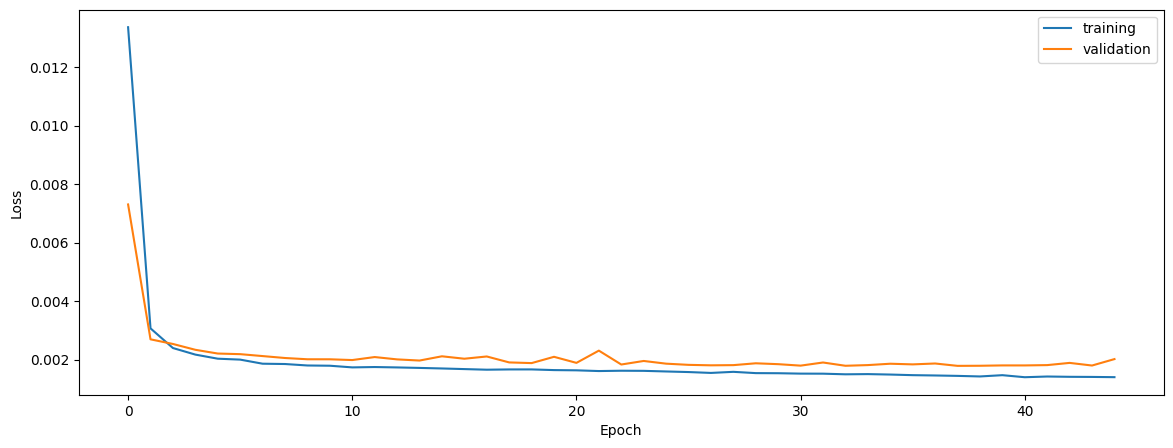

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


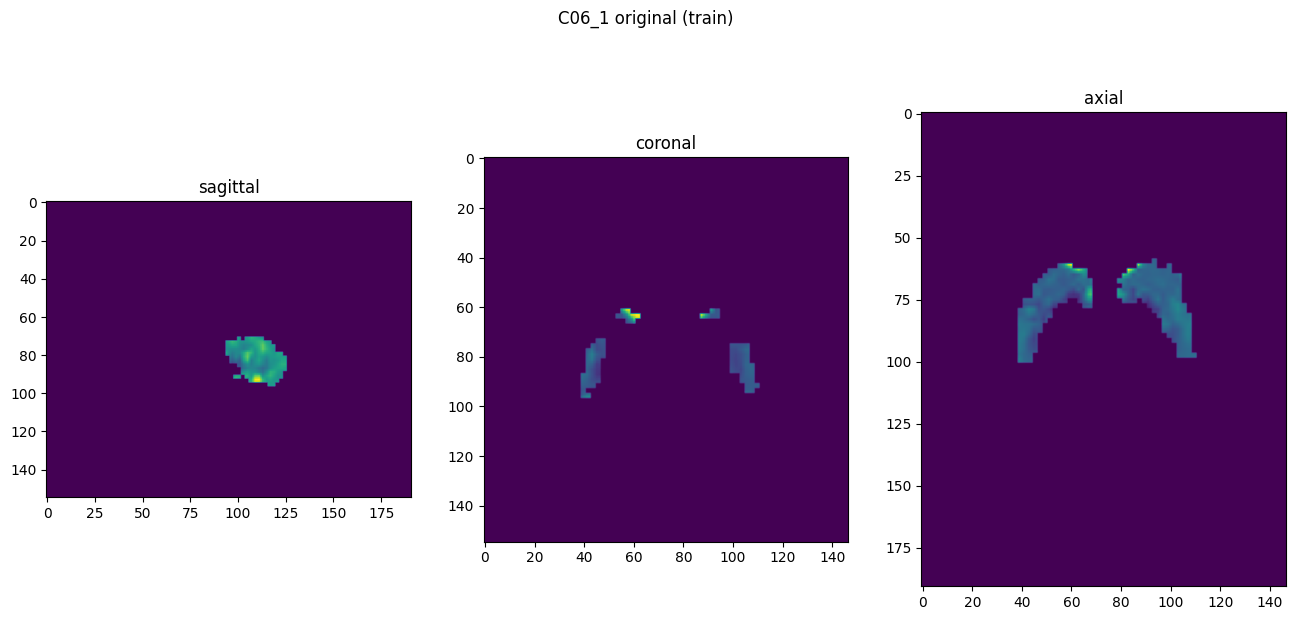

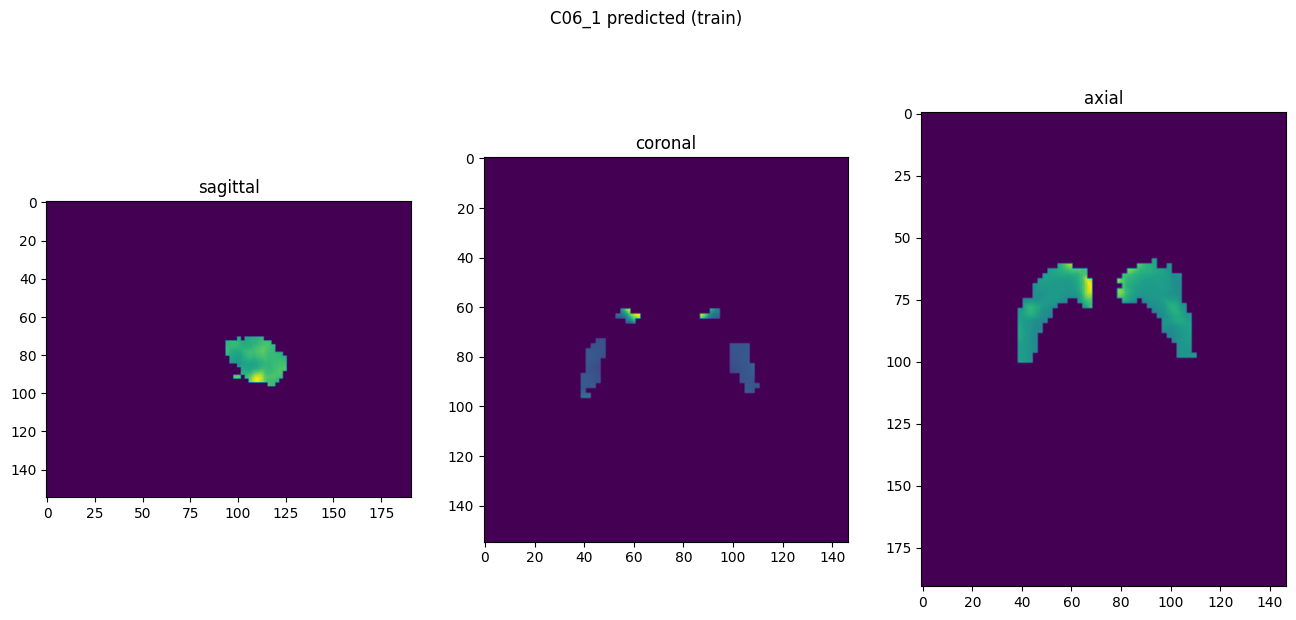

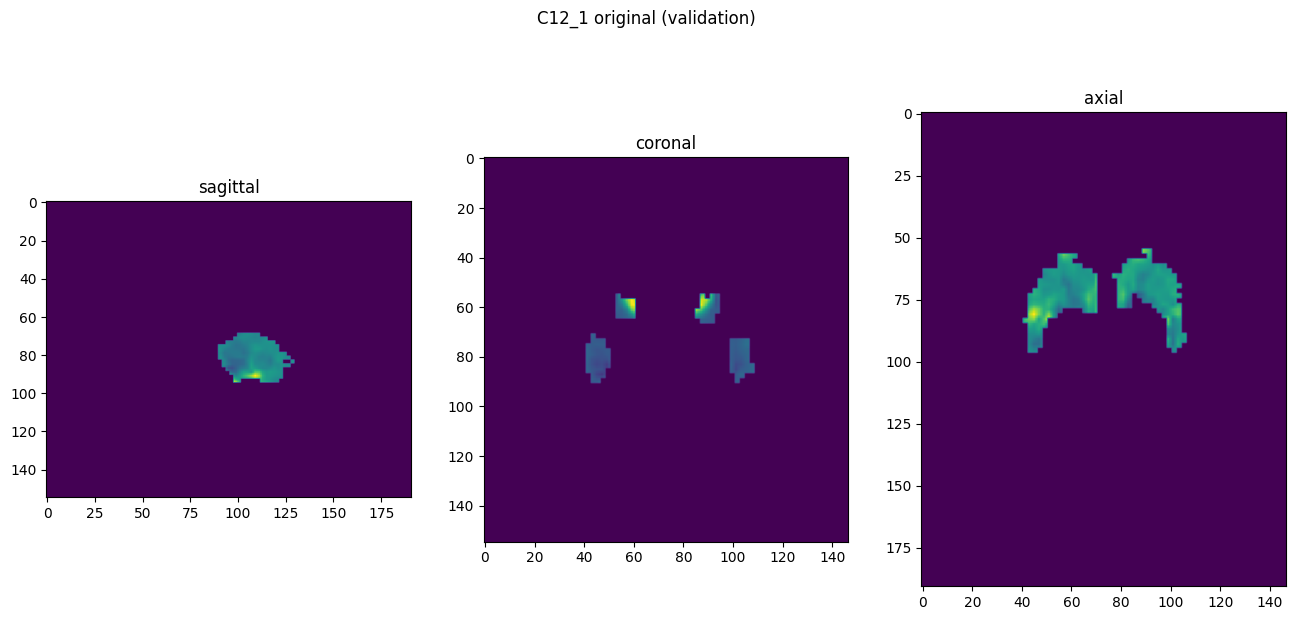

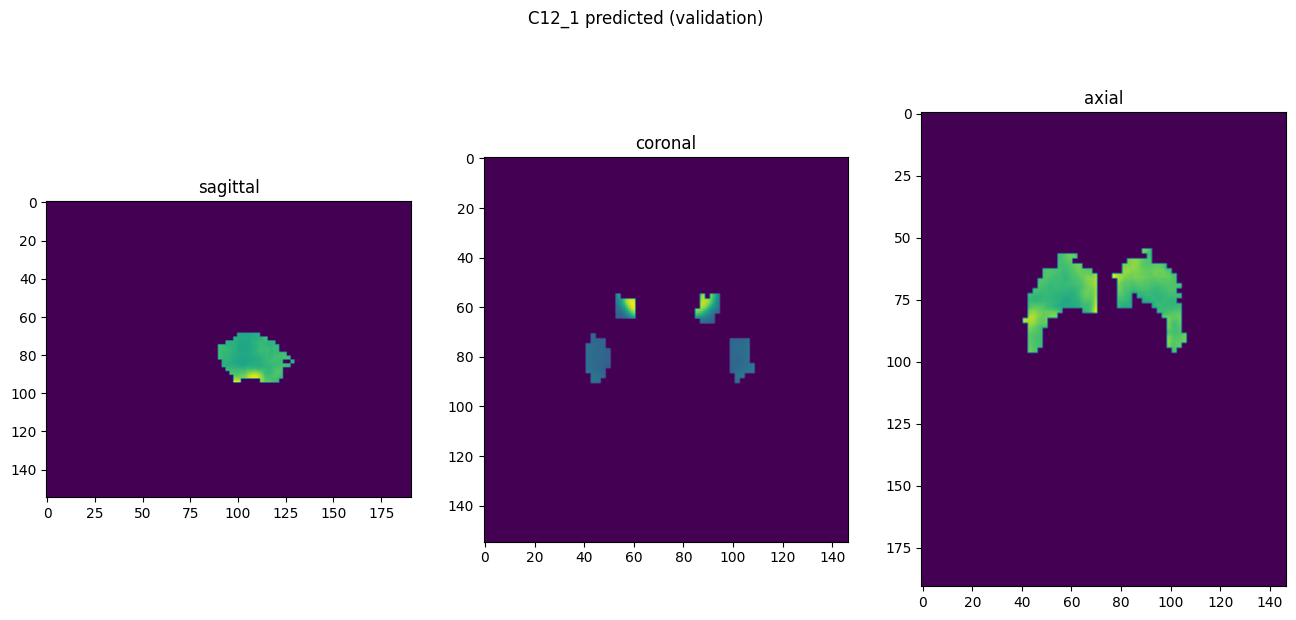

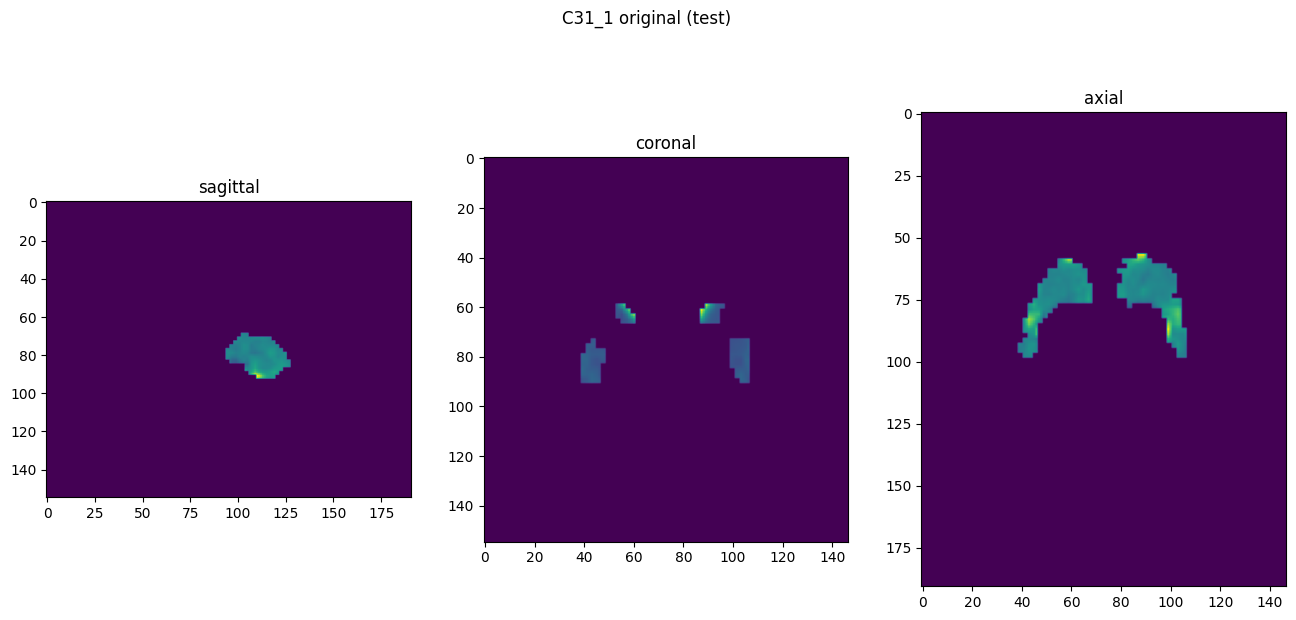

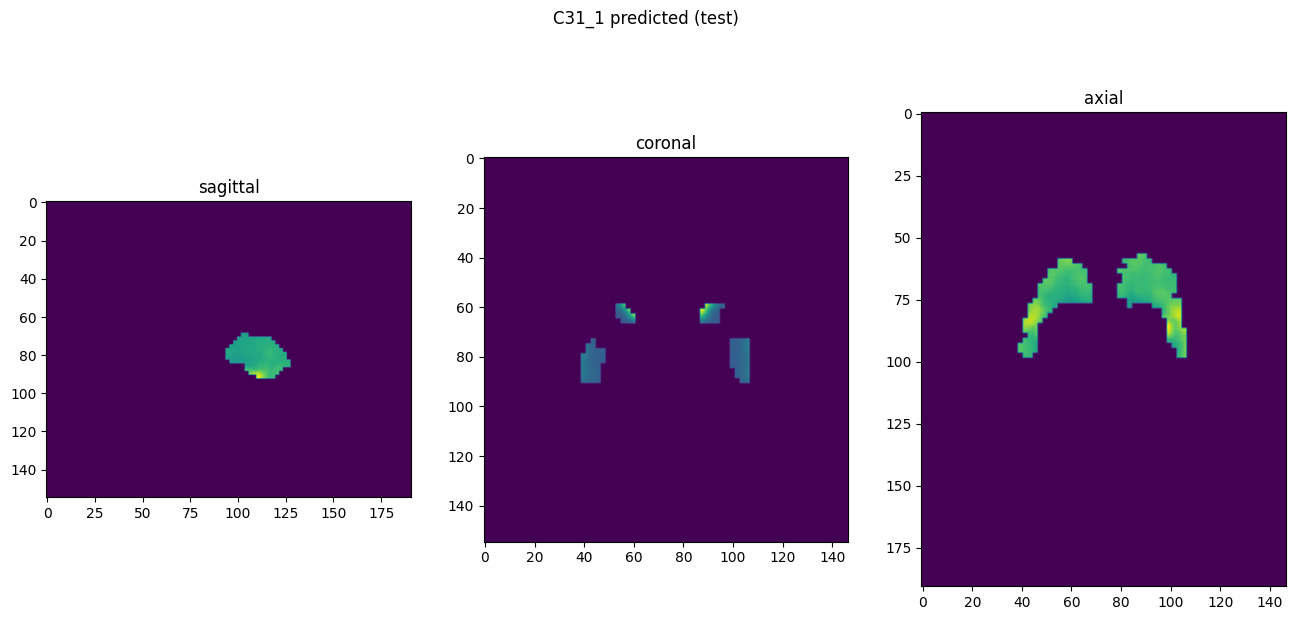

In [10]:
showResults(model, gen, threshold=None, background=False)